In [4]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression



In [5]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"

INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

ignored_subjects = []
duration = 12000
frequency = 200

should_save_models = True

In [6]:
raw_dataset = load_sisfall_data(dataset_folder, ignored_subjects, sensors)
raw_dataset


,subject,activity,trial,data
0,SA01,D01,R01,acc_x acc_y ...
1,SA01,D01,R01,acc_x acc_y ...
2,SA01,D01,R01,acc_x acc_y ...
3,SA01,D01,R01,acc_x acc_y ...
4,SA01,D01,R01,acc_x acc_y ...
...,...,...,...,...
5100,SE15,D17,R01,acc_x acc_y ...
5101,SE15,D17,R02,acc_x acc_y ...
5102,SE15,D17,R03,acc_x acc_y ...
5103,SE15,D17,R04,acc_x acc_y ...


In [7]:
import os
import re

def uma_search_csv_files(directory, activities_of_interest=None):
    csv_files = []
    for current_folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                if activities_of_interest is not None:
                    for activity in activities_of_interest:
                        # Use regex to match exact activity number
                        pattern = rf"{activity}(?=Trial|_|\.csv)"
                        if re.search(pattern, file):
                            full_path = os.path.join(current_folder, file)
                            csv_files.append(full_path)
                            break
                else:
                    full_path = os.path.join(current_folder, file)
                    csv_files.append(full_path)
    return csv_files


uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity4','Activity5','Activity6','Activity7','Activity8','Activity9','Activity10','Activity11','Activity12','Activity13','Activity14','Activity15'])

combined_uma_df = pd.concat([pd.read_csv(file) for file in uma_files], ignore_index=True)

combined_uma_df.rename(columns={
    'Accelerometer: x-axis (g)': 'acc_x',
    'Accelerometer: y-axis (g)': 'acc_y',
    'Accelerometer: z-axis (g)': 'acc_z',
    'Gyroscope: x-axis (rad/s)': 'gyro_x',
    'Gyroscope: y-axis (rad/s)': 'gyro_y',
    'Gyroscope: z-axis (rad/s)': 'gyro_z'
}, inplace=True)

# Display the shape of the combined dataframe
combined_uma_df[700:710]

,TimeStamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,Subject,Activity,Trial,Tag
700,7.338,0.133057,0.416016,0.91748,-0.086039,-0.017181,-0.044724,15,14,3,0
701,7.344,0.14209,0.4104,0.921387,-0.02918,0.011317,-0.022907,15,14,3,0
702,7.349,0.14209,0.4104,0.921387,-0.02918,0.011317,-0.022907,15,14,3,0
703,7.384,0.137695,0.414551,0.915039,-0.029589,0.016362,-0.048133,15,14,3,0
704,7.433,0.132812,0.406738,0.918213,-0.024135,-0.015544,-0.047178,15,14,3,0
705,7.579,0.140869,0.412842,0.91626,-0.019226,-0.006136,-0.047587,15,14,3,0
706,7.582,0.140869,0.412842,0.91626,-0.019226,-0.006136,-0.047587,15,14,3,0
707,7.628,0.144775,0.407715,0.921875,-0.072131,-0.009817,-0.046497,15,14,3,0
708,7.631,0.140381,0.468262,0.91748,-0.076358,-0.013908,-0.046224,15,14,3,0
709,7.774,0.138184,0.46582,0.918457,-0.077449,-0.004227,-0.041452,15,14,3,0


In [8]:
grouped_data = []

# Sort by Subject, Activity, Trial, and TimeStamp to ensure proper ordering
combined_df_sorted = combined_uma_df.sort_values(['Subject', 'Activity', 'Trial', 'TimeStamp']).reset_index(drop=True)

current_group = []
current_subject = None
current_activity = None
current_trial = None
group_id = 0

for idx, row in combined_df_sorted.iterrows():
    # Check if we're starting a new session (different subject/activity/trial)
    if (current_subject != row['Subject'] or 
        current_activity != row['Activity'] or 
        current_trial != row['Trial']):
        
        # Save the previous group if it exists
        if current_group:
            group_df = pd.DataFrame(current_group)

            if INCLUDE_GYROSCOPE:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
            else:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]

            timestamps = group_df['TimeStamp']
            
            group_row = {
                'subject': current_subject,
                'activity': f"D{current_activity}",
                'trial': current_trial,
                'group_id': group_id,
                'data': sensor_data,
                'timestamps': timestamps,
                'start_time': timestamps.iloc[0],
                'end_time': timestamps.iloc[-1],
                'duration': len(timestamps),
                'sampling_rate': len(timestamps) / (timestamps.iloc[-1] - timestamps.iloc[0]) if len(timestamps) > 1 else 0
            }
            grouped_data.append(group_row)
            group_id += 1
        
        # Start new group
        current_group = [row.to_dict()]
        current_subject = row['Subject']
        current_activity = row['Activity']
        current_trial = row['Trial']
    else:
        # Check if timestamp has reset/jumped backwards (indicating new data segment)
        if current_group:
            last_timestamp = current_group[-1]['TimeStamp']
            current_timestamp = row['TimeStamp']
            
            # If current timestamp is less than or equal to previous (reset occurred)
            if current_timestamp <= last_timestamp:
                # Save the current group
                group_df = pd.DataFrame(current_group)
                if INCLUDE_GYROSCOPE:
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
                else:   
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
                timestamps = group_df['TimeStamp']
                
                group_row = {
                    'subject': current_subject,
                    'activity': f"D{current_activity}",
                    'trial': current_trial,
                    'group_id': group_id,
                    'data': sensor_data,
                    'timestamps': timestamps,
                    'start_time': timestamps.iloc[0],
                    'end_time': timestamps.iloc[-1],
                    'duration': len(timestamps),
                    'sampling_rate': len(timestamps) / (timestamps.iloc[-1] - timestamps.iloc[0]) if len(timestamps) > 1 else 0
                }
                grouped_data.append(group_row)
                group_id += 1
                
                # Start new group with current row
                current_group = [row.to_dict()]
            else:
                # Continue adding to current group
                current_group.append(row.to_dict())
        else:
            current_group.append(row.to_dict())

# Don't forget the last group
if current_group:
    group_df = pd.DataFrame(current_group)
    if INCLUDE_GYROSCOPE:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
    else:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
    timestamps = group_df['TimeStamp']
    
    group_row = {
        'subject': current_subject,
        'activity': f"D{current_activity}",
        'trial': current_trial,
        'group_id': group_id,
        'data': sensor_data,
        'timestamps': timestamps,
        'start_time': timestamps.iloc[0],
        'end_time': timestamps.iloc[-1],
        'duration': len(timestamps),
        'sampling_rate': len(timestamps) / (timestamps.iloc[-1] - timestamps.iloc[0]) if len(timestamps) > 1 else 0
    }
    grouped_data.append(group_row)

# Convert to DataFrame
uma_dataset = pd.DataFrame(grouped_data)
print(f"Created {len(uma_dataset)} data segments based on timestamp breaks")
print(f"Segments per activity:")
activity_counts = uma_dataset['activity'].value_counts()
print(activity_counts)

# Show additional timestamp info
print(f"\nTimestamp information:")
print(f"Average segment duration: {uma_dataset['duration'].mean():.1f} samples")
print(f"Average sampling rate: {uma_dataset['sampling_rate'].mean():.1f} Hz")


Created 627 data segments based on timestamp breaks
Segments per activity:
activity
D13    68
D14    67
D15    63
D8     58
D1     55
D7     48
D4     47
D10    40
D9     39
D11    39
D12    37
D2     28
D5     19
D6     19
Name: count, dtype: int64

Timestamp information:
Average segment duration: 295.9 samples
Average sampling rate: 20.0 Hz


In [9]:
import itertools
import numpy as np


def extract_features(data, with_magnitude):
    """
    Extracts various features from the time and frequency domains from a given sample of activity. Also constructs
    features by combining the raw data.

    :param data: the data from the activity
    :param with_magnitude: calculate the magnitude of the sensors
    :return: list with all the features extracted from the activity
    """
    
    # Make a copy to avoid modifying original data
    data = data.copy()
    
    # Clean and ensure all data is numeric
    for col in data.columns:
        # Convert to string first, then replace any concatenated values
        data[col] = data[col].astype(str)
        # If values are concatenated, this won't work well, so let's handle it
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Fill any NaN values with 0
    data = data.fillna(0)
    
    # Check if we still have any non-numeric data
    if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
        print("Warning: Non-numeric data detected, attempting to clean...")
        # Additional cleaning if needed
        for col in data.columns:
            if data[col].dtype == 'object':
                print(f"Column {col} contains non-numeric data")
                data[col] = 0  # Set problematic columns to 0
    
    # Calculates the acceleration and rotation magnitudes
    if with_magnitude:
        for i in range(0, data.shape[1], 3):
            if i + 2 < data.shape[1]:  # Ensure we have 3 columns
                # Select the 3-axis slice
                slice_ = data.iloc[:, i:i+3]
                
                # Compute magnitude
                magnitude = np.linalg.norm(slice_, axis=1)
                
                # Generate magnitude column name
                name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                
                # Assign magnitude column
                data[name] = magnitude

    # Creates features vector name
    names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
    columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))

    # Time domain features
    features = np.mean(data, axis=0)
    features = np.hstack((features, np.var(data, axis=0)))
    features = np.hstack((features, np.std(data, axis=0)))
    features = np.hstack((features, np.median(data, axis=0)))
    features = np.hstack((features, np.max(data, axis=0)))
    features = np.hstack((features, np.min(data, axis=0)))
    features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
    features = np.hstack((features, np.percentile(data, 25, axis=0)))
    features = np.hstack((features, np.percentile(data, 75, axis=0)))

    # Creates a DataFrame
    features = pd.DataFrame([features], columns=columns)
    return features

# Extract features from uma_dataset
print("Processing UMA dataset...")
feature_list = []
labels = []
subjects = []
activity_codes = []

for i in uma_dataset.index:
    # Get data from each row
    data = uma_dataset['data'][i]
    
    # Extract features
    features_uma = extract_features(data, True)
    
    # Store results
    feature_list.append(features_uma)
    subjects.append(uma_dataset['subject'][i])
    activity_codes.append(uma_dataset['activity'][i])

# Combine into final dataset
uma_prepared_dataset = pd.concat(feature_list, ignore_index=True)
uma_prepared_dataset['subject'] = subjects
uma_prepared_dataset['activity_code'] = activity_codes

print(f"UMA dataset shape: {uma_prepared_dataset.shape}")
print("\nActivity code distribution:")
print(uma_prepared_dataset['activity_code'].value_counts())

uma_prepared_dataset

UMA_ACTIVITY_MAPPING = {
    'D1': 'adl',
    'D2': 'adl',
    'D3': 'adl',
    'D4': 'adl',
    'D5': 'adl',
    'D6': 'adl',
    'D7': 'adl',
    'D8': 'adl',
    'D9': 'adl',
    'D10': 'adl',
    'D11': 'adl',
    'D12': 'adl',
    'D13': 'fall',
    'D14': 'fall',
    'D15': 'fall'
}

activity_codes = uma_prepared_dataset['activity_code'] 
y_labels = activity_codes.map(UMA_ACTIVITY_MAPPING)


X_uma = uma_prepared_dataset.drop(columns=['activity_code', 'subject'])
X_uma


Processing UMA dataset...
UMA dataset shape: (627, 38)

Activity code distribution:
activity_code
D13    68
D14    67
D15    63
D8     58
D1     55
D7     48
D4     47
D10    40
D9     39
D11    39
D12    37
D2     28
D5     19
D6     19
Name: count, dtype: int64


,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
0,-0.748402,0.572373,0.265424,0.989671,0.010993,0.009095,0.012568,0.011373,0.104850,0.095367,...,0.669189,0.620804,-0.812744,0.504150,0.204346,0.918750,-0.674072,0.633789,0.338379,1.046824
1,-0.648921,0.610286,0.361364,0.999880,0.036785,0.015908,0.038167,0.015232,0.191793,0.126126,...,1.385986,1.390414,-0.765381,0.549805,0.231689,0.928399,-0.610352,0.674561,0.394531,1.055870
2,-0.642502,0.666831,0.311903,0.985959,0.010756,0.009004,0.008315,0.010715,0.103709,0.094890,...,0.555420,0.583319,-0.731873,0.600159,0.235718,0.917690,-0.567505,0.749023,0.382202,1.034498
3,-0.498375,0.661134,0.505503,0.997373,0.031520,0.007708,0.017795,0.003278,0.177540,0.087794,...,0.644287,0.500824,-0.655640,0.589600,0.411072,0.969304,-0.280518,0.717773,0.647644,1.021888
4,-0.511133,0.656781,0.448539,1.002200,0.063809,0.023132,0.034690,0.011031,0.252604,0.152091,...,0.807129,1.142747,-0.735840,0.553833,0.277100,0.963457,-0.266602,0.748413,0.624756,1.031452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,3.726074,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969
623,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,7.896973,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671
624,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.515381,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290
625,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,3.291016,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350


In [10]:
ACTIVITY_CLASSES = {
    'adl': ['D01', 'D02','D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19'],
    'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11","F12","F13", "F14","F15"],
}

# Create code to class mapping
CODE_TO_CLASS = {}
for class_name, codes in ACTIVITY_CLASSES.items():
    for code in codes:
        CODE_TO_CLASS[code] = class_name

print("Activity classes defined:")
for class_name, codes in ACTIVITY_CLASSES.items():
    print(f"  {class_name}: {codes}")

Activity classes defined:
  adl: ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19']
  fall: ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15']


In [11]:
def prepare_dataset(raw_dataset, CODE_TO_CLASS, duration, frequency):
    """
    Prepare dataset by filtering activities, extracting features, and organizing data.
    
    Parameters:
    raw_dataset: Raw dataset containing 'activity', 'data', and 'subject' columns
    CODE_TO_CLASS: Dictionary mapping activity codes to class labels
    duration: Duration parameter for activity processing
    frequency: Frequency parameter for activity sampling
    
    Returns:
    pd.DataFrame: Prepared dataset with features, class labels, subjects, and activity codes
    """
    
    # Filter indices based on activity codes
    filtered_indices = []
    for i in raw_dataset.index:
        activity_code = raw_dataset['activity'][i]
        if activity_code in CODE_TO_CLASS:
            filtered_indices.append(i)

    print(f"Total samples: {len(raw_dataset)}")
    print(f"Filtered samples: {len(filtered_indices)}")

    print("Processing data...")
    feature_list = []
    labels = []
    subjects = []
    activity_codes = []

    for i in filtered_indices:
        # Get data and preprocess
        data = raw_dataset['data'][i]
        data = change_activity_duration(data, duration)
        data = change_activity_sampling(data, frequency)
        
        # Extract features
        features = extract_features(data, True)
        
        # Get class label
        activity_code = raw_dataset['activity'][i]
        class_label = CODE_TO_CLASS[activity_code]
        
        # Store results
        feature_list.append(features)
        labels.append(class_label)
        subjects.append(raw_dataset['subject'][i])
        activity_codes.append(activity_code)

    # Combine into final dataset
    prepared_dataset = pd.concat(feature_list, ignore_index=True)
    prepared_dataset['class'] = labels
    prepared_dataset['subject'] = subjects
    prepared_dataset['activity_code'] = activity_codes

    print(f"Final dataset shape: {prepared_dataset.shape}")
    print("\nClass distribution:")
    print(prepared_dataset['class'].value_counts())
    
    return prepared_dataset

In [12]:
prepared_dataset = prepare_dataset(raw_dataset, CODE_TO_CLASS, duration, frequency)
prepared_dataset

Total samples: 5105
Filtered samples: 5105
Processing data...
Final dataset shape: (5105, 39)

Class distribution:
class
adl     3307
fall    1798
Name: count, dtype: int64


,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class,subject,activity_code
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,adl,SA01,D01
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,adl,SA01,D01
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,adl,SA01,D01
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,adl,SA01,D01
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,adl,SA01,D01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5100,0.003481,-0.868242,-0.343172,1.003846,0.058301,0.018607,0.061480,0.002305,0.241457,0.136407,...,-0.984375,-0.535156,0.986576,0.148438,-0.769531,-0.085938,1.019737,adl,SE15,D17
5101,0.076816,-0.890903,-0.265866,1.003875,0.057662,0.017463,0.064183,0.001836,0.240128,0.132148,...,-0.980469,-0.484375,0.992606,0.191406,-0.816406,-0.062500,1.011398,adl,SE15,D17
5102,-0.048776,-0.919728,-0.203848,1.004807,0.036690,0.017906,0.066739,0.001531,0.191548,0.133812,...,-1.000000,-0.375000,0.993699,0.003906,-0.863281,-0.019531,1.016017,adl,SE15,D17
5103,0.013631,-0.886082,-0.264712,1.004711,0.054687,0.020477,0.081273,0.002392,0.233853,0.143096,...,-0.996094,-0.507812,0.988609,0.101562,-0.753906,-0.031250,1.016284,adl,SE15,D17


In [13]:
from sklearn.model_selection import train_test_split


X_train,X_test = train_test_split(prepared_dataset, 
    test_size=0.2, 
    stratify=prepared_dataset['class'], 
    random_state=42
)

y_train = X_train['class']
y_test = X_test['class']

X_train = X_train.drop(columns=['class', 'subject', 'activity_code'])
X_test = X_test.drop(columns=['class', 'subject', 'activity_code'])



In [14]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_uma_scaled = scaler.transform(X_uma)

# # Step 2: Feature selection (fit only on training set)
sfm = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
sfm.fit(X_train_scaled, y_train)

# # Step 3: Transform all sets
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)
X_uma_selected = sfm.transform(X_uma_scaled)

In [15]:
final_X_train = X_train_selected
final_X_test = X_test_selected
final_X_uma = X_uma_selected


In [16]:

from sklearn.ensemble import GradientBoostingClassifier

def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

# X_train = preprocessing.StandardScaler().fit_transform(X_train)
# X_test = preprocessing.StandardScaler().fit_transform(X_test)

svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(final_X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(final_X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(final_X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(final_X_train, y_train)


lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(final_X_train, y_train)


gb = GradientBoostingClassifier( random_state=42)
gb.fit(final_X_train, y_train)


if should_save_models:
    suffix = '_gyro' if INCLUDE_GYROSCOPE else ''
    save_model(svm, models_output_folder + f'adl_fall_svm_model{suffix}.pkl')
    save_model(rf, models_output_folder + f'adl_fall_rf_model{suffix}.pkl')
    save_model(knn, models_output_folder + f'adl_fall_knn_model{suffix}.pkl')
    save_model(dt, models_output_folder + f'adl_fall_dt_model{suffix}.pkl')
    save_model(lr, models_output_folder + f'adl_fall_lr_model{suffix}.pkl')
    save_model(gb, models_output_folder + f'adl_fall_gb_model{suffix}.pkl')


Model saved to models/adl_fall_svm_model.pkl
Model saved to models/adl_fall_rf_model.pkl
Model saved to models/adl_fall_knn_model.pkl
Model saved to models/adl_fall_dt_model.pkl
Model saved to models/adl_fall_lr_model.pkl
Model saved to models/adl_fall_gb_model.pkl


Model: SVC
Classification Report:
              precision    recall  f1-score   support

         adl       0.99      1.00      0.99       661
        fall       0.99      0.99      0.99       360

    accuracy                           0.99      1021
   macro avg       0.99      0.99      0.99      1021
weighted avg       0.99      0.99      0.99      1021

Confusion Matrix:
Accuracy: 0.9922



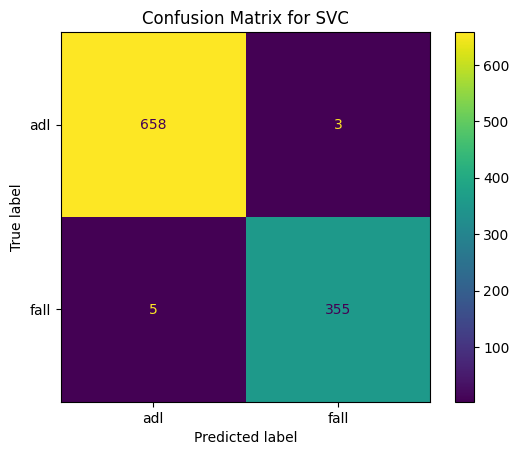

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       0.99      1.00      0.99       661
        fall       0.99      0.98      0.99       360

    accuracy                           0.99      1021
   macro avg       0.99      0.99      0.99      1021
weighted avg       0.99      0.99      0.99      1021

Confusion Matrix:
Accuracy: 0.9902



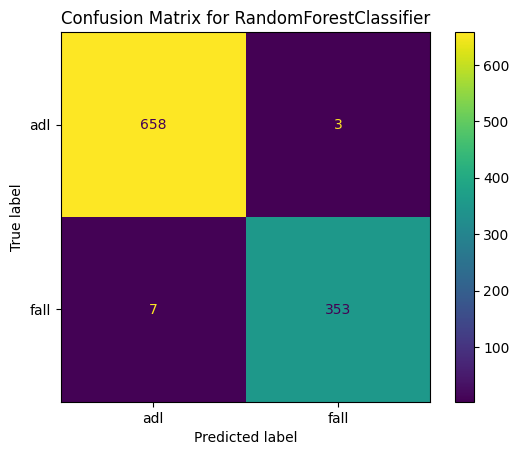

Model: KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       0.99      1.00      0.99       661
        fall       1.00      0.98      0.99       360

    accuracy                           0.99      1021
   macro avg       0.99      0.99      0.99      1021
weighted avg       0.99      0.99      0.99      1021

Confusion Matrix:
Accuracy: 0.9912



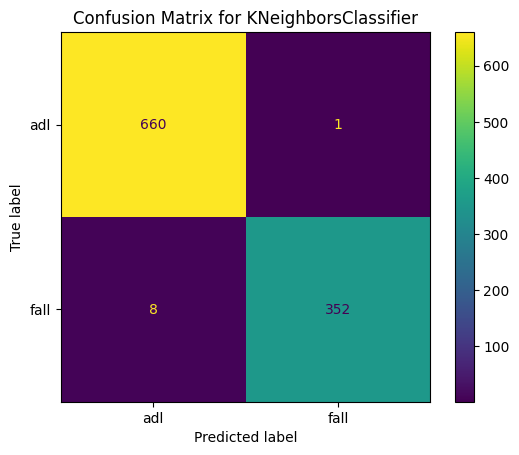

Model: DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       0.98      0.98      0.98       661
        fall       0.97      0.97      0.97       360

    accuracy                           0.98      1021
   macro avg       0.98      0.98      0.98      1021
weighted avg       0.98      0.98      0.98      1021

Confusion Matrix:
Accuracy: 0.9785



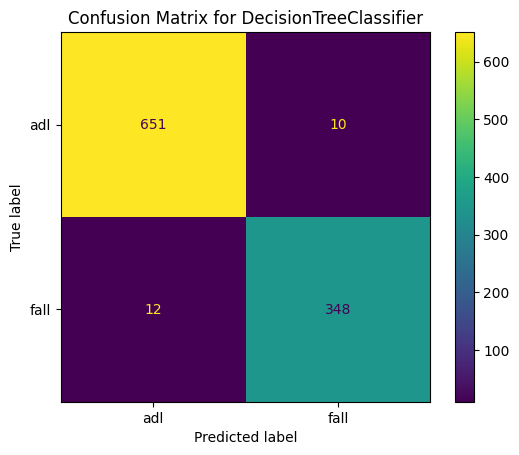

Model: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

         adl       0.96      0.98      0.97       661
        fall       0.96      0.93      0.94       360

    accuracy                           0.96      1021
   macro avg       0.96      0.95      0.96      1021
weighted avg       0.96      0.96      0.96      1021

Confusion Matrix:
Accuracy: 0.9608



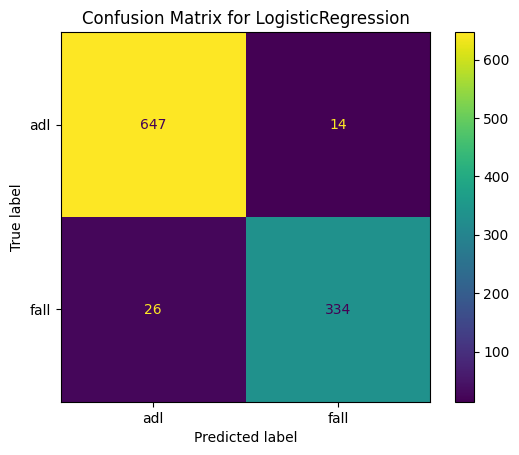

Model: GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       0.99      1.00      0.99       661
        fall       0.99      0.99      0.99       360

    accuracy                           0.99      1021
   macro avg       0.99      0.99      0.99      1021
weighted avg       0.99      0.99      0.99      1021

Confusion Matrix:
Accuracy: 0.9922



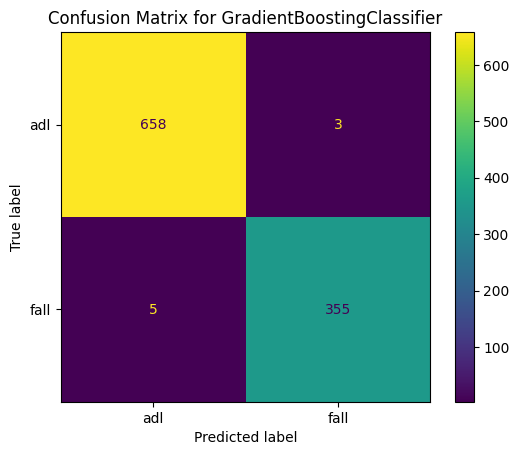

In [17]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

# Evaluate all models
evaluate_model(svm, final_X_test, y_test)
evaluate_model(rf, final_X_test, y_test)
evaluate_model(knn, final_X_test, y_test)
evaluate_model(dt, final_X_test, y_test)
evaluate_model(lr, final_X_test, y_test)
evaluate_model(gb, final_X_test, y_test)

In [18]:
predict_uma_svm = svm.predict(final_X_uma)

predict_uma_rf = rf.predict(final_X_uma)

predict_uma_knn = knn.predict(final_X_uma)

predict_uma_dt = dt.predict(final_X_uma)

predict_uma_lr = lr.predict(final_X_uma)

predict_gb = gb.predict(final_X_uma)

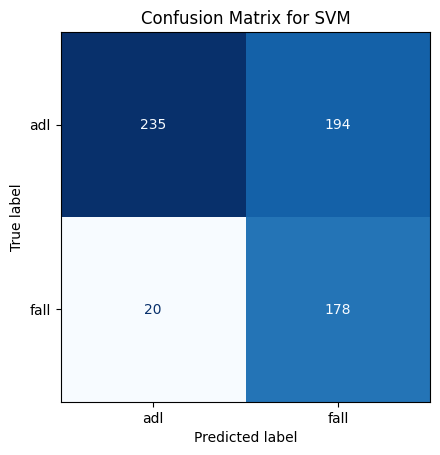

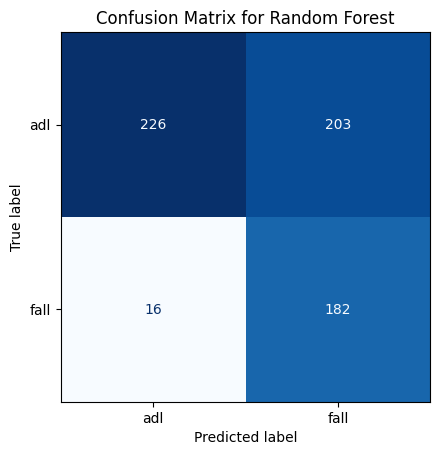

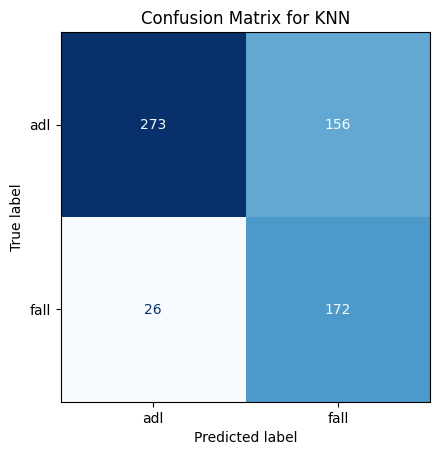

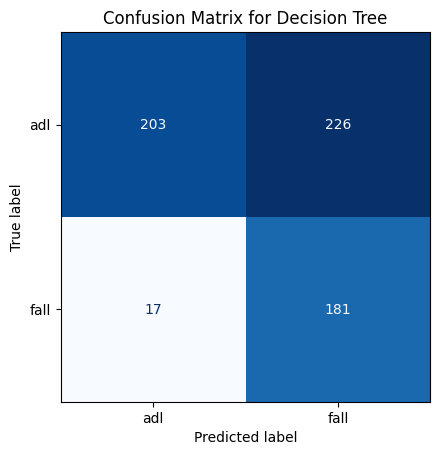

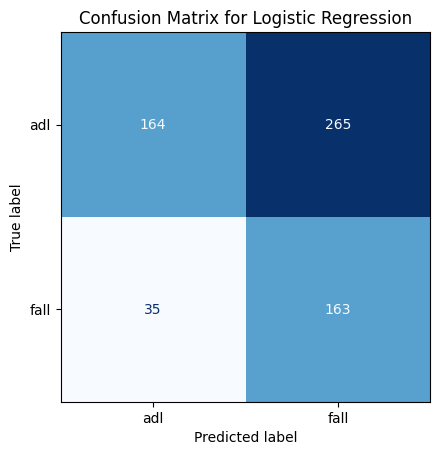

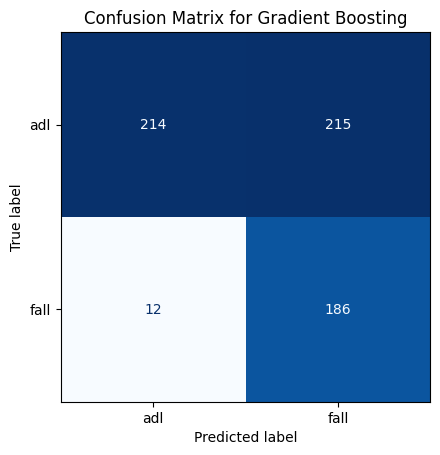

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

# map over models and plot confusion matrices
models = {
    'SVM': predict_uma_svm,
    'Random Forest': predict_uma_rf,
    'KNN': predict_uma_knn,
    'Decision Tree': predict_uma_dt,
    'Logistic Regression': predict_uma_lr,
    'Gradient Boosting': predict_gb
}
for model_name, predictions in models.items():
    cm = confusion_matrix(y_labels, predictions)
    unique_classes = np.unique(np.concatenate((y_labels, predictions)))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
    disp.plot(cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()




              true_label  predicted_fall  predicted_adl  total_samples
activity_code                                                         
D1                   adl               8             47             55
D10                  adl              20             20             40
D11                  adl              16             23             39
D12                  adl              14             23             37
D13                 fall              63              5             68
D14                 fall              63              4             67
D15                 fall              56              7             63
D2                   adl              16             12             28
D4                   adl              37             10             47
D5                   adl               3             16             19
D6                   adl               5             14             19
D7                   adl              34             14             48
D8    

/var/folders/b5/8qvrx5b94rv2txsfvw8tjdj00000gn/T/ipykernel_79017/601243298.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  confusion_by_activity = uma_results.groupby('activity_code').apply(


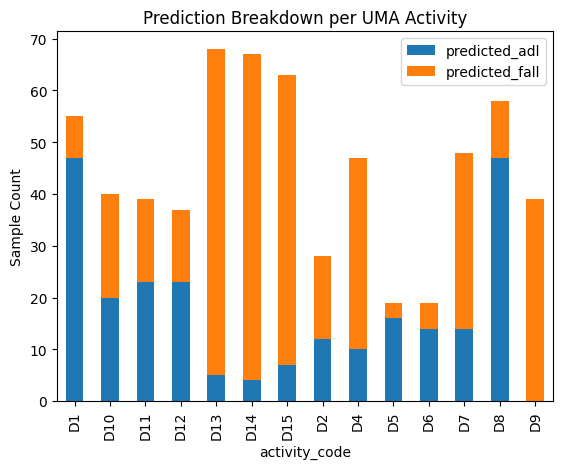

In [20]:
uma_results = uma_prepared_dataset.copy()
uma_results['true_class'] = y_labels.values
uma_results['predicted_rf'] = predict_uma_rf

# Group by actual activity_code
confusion_by_activity = uma_results.groupby('activity_code').apply(
    lambda df: pd.Series({
        'true_label': df['true_class'].iloc[0],
        'predicted_fall': (df['predicted_rf'] == 'fall').sum(),
        'predicted_adl': (df['predicted_rf'] == 'adl').sum(),
        'total_samples': len(df)
    })
)

import pandas as pd
import matplotlib.pyplot as plt

# Display misclassification per activity
print(confusion_by_activity)

# Optional: plot it
confusion_by_activity[['predicted_adl', 'predicted_fall']].plot(kind='bar', stacked=True)
plt.title("Prediction Breakdown per UMA Activity")
plt.ylabel("Sample Count")
plt.show()

In [21]:
probs = gb.predict_proba(final_X_uma)
high_confidence_mask = (probs.max(axis=1) > 0.9)

X_pseudo = final_X_uma[high_confidence_mask]
y_pseudo = gb.predict(final_X_uma[high_confidence_mask])

# Combine with training data
X_combined = np.vstack([X_train_selected, X_pseudo])
y_combined = np.hstack([y_train, y_pseudo])

# Retrain model
gb.fit(X_combined, y_combined)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


Model: GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       0.95      0.49      0.65       429
        fall       0.46      0.94      0.62       198

    accuracy                           0.63       627
   macro avg       0.71      0.72      0.63       627
weighted avg       0.80      0.63      0.64       627

Confusion Matrix:
Accuracy: 0.6332



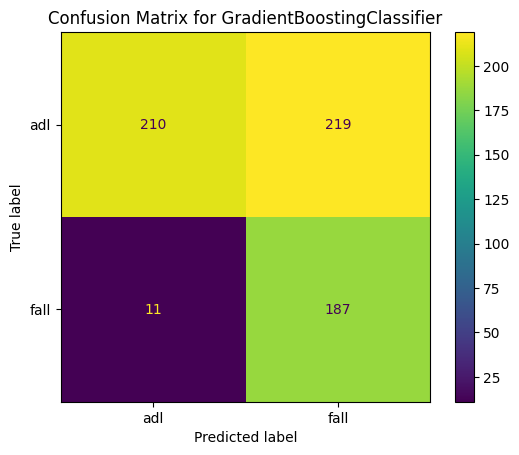

In [ ]:
# # gb_probs = gb.predict_proba(final_X_uma)
# # gb_high_confidence_mask = (gb_probs.max(axis=1) > 0.9)
# # gb_X_pseudo = final_X_uma[gb_high_confidence_mask]
# # gb_y_pseudo = gb.predict(final_X_uma[gb_high_confidence_mask])  
# # # Combine with training data
# # gb_X_combined = np.vstack([X_train_selected, gb_X_pseudo])
# # gb_y_combined = np.hstack([y_train, gb_y_pseudo])
# # # Retrain model
# # gb.fit(gb_X_combined, gb_y_combined)

# # Evaluate the updated model
# evaluate_model(gb, final_X_uma, y_labels)